# Collaborative Filtering
***

## Table of Contents
***
1. [Introduction](#intro)
1. [Loading](#load)
1. [Sparsity](#sparsity)
1. [User-Based](#user)
1. [Item-Based](#item)
1. [RMSE](#rmse)
1. [Recommender](#recommender)
1. [Conclusion](#conclusion)

## Introduction <a name="intro">
***
Collaborative Filtering (CF) explores the idea that relationships exist between products (movies) and people's interests(ratings). Many recommender systems, use Collaborative Filtering to realize these relationships and to give an accurate recommendation of a product that the user may like or enjoy.

CF bases these relationships on choices that a user makes when buying, watching or enjoying something. Then makes connections with other users of similar interest to produce a prediction. So users get a broader exposure to different products they might be interested in. In this notebook, we will explore user-based and item-based CF to make recommendations.

## Loading <a name="load">
***
Let's load all the necessary packages and datasets to build a recommendation system.

In [30]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
rat = pd.read_csv('ml-latest-small/cleaned_ratings.csv')
movies = pd.read_csv('ml-latest-small/cleaned_movies.csv')

In [32]:
ratings = rat.merge(movies[['movieId','title']],on='movieId').sort_values(by='movieId').reset_index()

In [33]:
ratings.head()

,index,userId,movieId,rating,date,year,month,day,hour,title
0,31535,586,1,4.0,2008-06-23 15:16:42,2008,6,23,15,Toy Story (1995)
1,31471,434,1,4.0,1998-02-01 22:39:06,1998,2,1,22,Toy Story (1995)
2,31472,437,1,4.0,1996-05-10 02:00:10,1996,5,10,2,Toy Story (1995)
3,31473,440,1,4.0,1996-06-21 06:04:17,1996,6,21,6,Toy Story (1995)
4,31474,442,1,4.0,2008-11-29 00:53:52,2008,11,29,0,Toy Story (1995)


In [34]:
print('Num. of Users: '+ str(ratings['userId'].nunique()))
print('Num of Movies: '+str(ratings['movieId'].nunique()))

Num. of Users: 671
Num of Movies: 9066


There are 671 users and 9,066 movies in the dataset. To make a recommender system, one only needs enough user and products data to make recommendations. There is no need of more features or even feature engineering as it is required in regression or classification. Let's create the user-item matrix for the dataset.

In [35]:
movie_ratings = ratings.pivot_table(index=['userId'],columns=['title'],values='rating')
movie_ratings.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Sparsity <a name="sparsity">
***
A sparse matrix is a matrix in which most of the elements are zero or missing. Data sparsity is a challenge in Collaborative Filtering. The user-item matrix tends to be large and sparse. It may provide a good level of accuracy if we have a larger dataset but also poses a risk to speed. Let's check the sparsity of the matrix.

In [36]:
def sparsity(matrix):
    # get amount of non-zero values
    sparsity = float(np.count_nonzero(~np.isnan(movie_ratings.values)))
    # divide by the total number of user-items
    sparsity /= (matrix.shape[0] * matrix.shape[1])
    sparsity *= 100
    print('Sparsity: {:4.2f}%'.format(100-sparsity))

In [37]:
sparsity(movie_ratings.values)

Sparsity: 98.36%


The dataset has 98.36% sparsity which means that 98.36% of the user-item ratings are missing.

## User-Based <a name="user">
***
User-Based CF looks at all the users that are most similar to *userA* who have also rated *item i*. After finding the users similar to each other based on their rating behavior, we can recommend movies that others liked and are similar to the user.

In [38]:
user_one_ratings = movie_ratings.loc[1]
user_one_ratings.head()

title
"Great Performances" Cats (1998)          NaN
$9.99 (2008)                              NaN
'Hellboy': The Seeds of Creation (2004)   NaN
'Neath the Arizona Skies (1934)           NaN
'Round Midnight (1986)                    NaN
Name: 1, dtype: float64

In [39]:
user_one_ratings.shape

(9064,)

In [40]:
user_one_ratings.dropna().sort_values(ascending=False)[:5]

title
French Connection, The (1971)                     4.0
Tron (1982)                                       4.0
Cinema Paradiso (Nuovo cinema Paradiso) (1989)    4.0
Dracula (Bram Stoker's Dracula) (1992)            3.5
Dumbo (1941)                                      3.0
Name: 1, dtype: float64

The ratings for *userId 1* are above and since the user has not rated all the movies, we see some NaN values.

By substracting the row mean or the average rating of the user to each rating, we can normalize ratings for a given user. Centered cosine similarity is equivalent to the Pearson correlation coefficient. The missing ratings are treated as zeroes and we do not substract the mean from them. Now let's get similar users of *userId 1*.

In [41]:
similar_users = movie_ratings.corrwith(user_one_ratings,axis=1)
similar_users = similar_users.dropna()
df = pd.DataFrame(similar_users)
df.head(10)

/Users/andrew/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3159: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


,0
userId,
1,1.000000
4,0.068752
7,-0.912871
15,0.008433
17,-1.000000
19,0.117851
21,-0.522233
22,0.737043
23,-0.050965


In [42]:
similar_users.sort_values(ascending=False)[:10]

userId
1      1.0
458    1.0
574    1.0
198    1.0
197    1.0
103    1.0
243    1.0
403    1.0
617    1.0
594    1.0
dtype: float64

In [43]:
movie_ratings.loc[[1,594]].dropna(axis=1)

title,"French Connection, The (1971)","Gods Must Be Crazy, The (1980)"
userId,,
1,4.0,3.0
594,5.0,4.0


After sorting, we see that some of the users in the dataset are completely similar to *userId 1*. However, some of the most related users have only rated low number of movies compared to *userId 1*. Let's make sure we can set a threshold of minimum percentage of similar movies rated by users.

In [44]:
print('userId 1 rated {} movies in total'.format(len(movie_ratings.loc[1].dropna())))

userId 1 rated 20 movies in total


In [45]:
total_similar_movies = [sum(movie_ratings.loc[i].dropna().index.isin(movie_ratings.loc[1].dropna().index)) / len(movie_ratings.loc[1].dropna()) * 100  for i in similar_users.index]

In [46]:
percentage_similar = pd.DataFrame(similar_users)
percentage_similar['percentage_similar_movies'] = total_similar_movies
percentage_similar.head()

,0,percentage_similar_movies
userId,,
1,1.000000,100.0
4,0.068752,25.0
7,-0.912871,25.0
15,0.008433,55.0
17,-1.000000,10.0


Now we have a dataframe with the similarity and also the percentage of similar movies rated between *userId 1* and the other users. Let's make sure we take into account only users that have rated at leat 50% of the movies that *userId 1* has rated.

In [47]:
most_similar_users = percentage_similar['percentage_similar_movies'] >= 50
most_similar_users.head()

userId
1      True
4     False
7     False
15     True
17    False
Name: percentage_similar_movies, dtype: bool

In [48]:
percentage_similar[most_similar_users].sort_values([(0)], ascending=False)[:10]

,0,percentage_similar_movies
userId,,
1,1.000000,100.0
580,0.665768,60.0
547,0.269749,55.0
461,0.146905,55.0
472,0.144668,55.0
564,0.116717,80.0
452,0.113350,55.0
509,0.083295,50.0
195,0.027905,60.0


In [49]:
movie_ratings.loc[[1,580]].dropna(axis=1)

title,Antz (1998),Beavis and Butt-Head Do America (1996),Blazing Saddles (1974),Cape Fear (1991),Cinema Paradiso (Nuovo cinema Paradiso) (1989),Dracula (Bram Stoker's Dracula) (1992),Escape from New York (1981),"Gods Must Be Crazy, The (1980)",Star Trek: The Motion Picture (1979),Time Bandits (1981),Tron (1982),Willow (1988)
userId,,,,,,,,,,,,
1,2.0,1.0,3.0,2.0,4.0,3.5,2.0,3.0,2.5,1.0,4.0,2.0
580,3.0,1.5,4.0,3.5,4.0,3.0,2.0,3.5,2.5,3.0,4.0,3.5


The table shows that *userId 580* has rated at least more than 50% of the movies and is the most similar to *userId 1* with a similarity of *0.66*. Now we can recommend movies that *userId 580* has rated 5 stars and that *userId 1* has not yet rated. 

In [50]:
movie_ratings.loc[[580]].dropna(axis=1).T.sort_values(by=580,ascending=False)[:10]

userId,580
title,
"Godfather, The (1972)",5.0
Donnie Darko (2001),5.0
Stranger than Fiction (2006),5.0
Fight Club (1999),5.0
"Dark Knight, The (2008)",5.0
Full Metal Jacket (1987),4.5
Freeway (1996),4.5
Lost in Translation (2003),4.5
Bringing Out the Dead (1999),4.5


According to our User-Based Recommender, the best movies to recommend to *userId 1* are [The Godfather](), [Donnie Darko](https://www.imdb.com/title/tt0246578) and [Stranger than Fiction](https://www.imdb.com/title/tt0420223). Tron and Cinema Paradiso are two of *userId 1* highest rated movies and both are almost 30 years old. As well, Tron is a sci-fi movie and Cinema Paradiso is a Drama. From the recommendations The Godfather was aired more than 30 years ago. Donnie Darko is a sci-fi movie and Stranger than Fiction is a Drama. The 3 movies might appeal to *userId 1*. Remember that reducing our threshold of percentage of similar movies can give completely different results, better or worse. 

## Item-Based <a name="item">
***
Now let's approach the recommendation problem from a different perspective. Instead of basing our recommendations on relationships between users, we base them on relationships between items and that is Item-Based CF. In this case, similarity means how users treat other items the same in terms of like or dislike. For example, do users that liked [Toy Story](https://www.imdb.com/title/tt0114709) will like [Indiana Jones](https://www.imdb.com/title/tt0097576)? This algorithm tends to be more stable since the average movie tends to have more ratings than the average user.

In [51]:
toy_story_ratings = movie_ratings['Toy Story (1995)']
toy_story_ratings.head()

userId
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: Toy Story (1995), dtype: float64

In [52]:
toy_story_ratings.shape

(671,)

So we first got all the ratings of the movie Toy Story. The data shows 671 ratings; however, there are plenty of NaN values since not all users have rated it. Now let's find the correlation between Toy Story and all the other movies in the dataset.  

In [53]:
similar_movies = movie_ratings.corrwith(toy_story_ratings)
similar_movies = similar_movies.dropna()
df = pd.DataFrame(similar_movies)
df.head(10)

/Users/andrew/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3159: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


,0
title,
"'burbs, The (1989)",0.124060
(500) Days of Summer (2009),0.407521
*batteries not included (1987),-0.579186
...And Justice for All (1979),-0.385758
10 (1979),0.277350
10 Cloverfield Lane (2016),0.866025
10 Things I Hate About You (1999),-0.045788
"10,000 BC (2008)",-0.275839
101 Dalmatians (1996),0.453423


In [54]:
similar_movies.sort_values(ascending=False)[:10]

title
Case 39 (2009)                                                      1.0
Toy, The (1982)                                                     1.0
Chocolate (2008)                                                    1.0
Anne of Green Gables: The Sequel (a.k.a. Anne of Avonlea) (1987)    1.0
Mixed Nuts (1994)                                                   1.0
Gigli (2003)                                                        1.0
Before Midnight (2013)                                              1.0
Animal Kingdom (2010)                                               1.0
Lilya 4-Ever (Lilja 4-ever) (2002)                                  1.0
Lady Snowblood (Shurayukihime) (1973)                               1.0
dtype: float64

After sorting, [Lady Snowblood](https://www.imdb.com/title/tt0158714/) looks like it is similar to Toy Story. However, this might be misleading due to the amount of ratings each movie has. There are movies that have only been viewed by a handful of people who also happened to like Toy Story. Let's make sure we can count the number of ratings each movie has.

In [55]:
movie_stats = ratings.groupby('title').agg({'rating': [np.size, np.mean]})
movie_stats.head()

rating          
                                          size      mean
title                                                   
"Great Performances" Cats (1998)           2.0  1.750000
$9.99 (2008)                               3.0  3.833333
'Hellboy': The Seeds of Creation (2004)    1.0  2.000000
'Neath the Arizona Skies (1934)            1.0  0.500000
'Round Midnight (1986)                     2.0  2.250000

In [56]:
popular_movies = movie_stats['rating']['size'] >= 100
movie_stats[popular_movies].sort_values([('rating', 'mean')], ascending=False)[:10]

rating          
                                         size      mean
title                                                  
Godfather, The (1972)                   200.0  4.487500
Shawshank Redemption, The (1994)        311.0  4.487138
Godfather: Part II, The (1974)          135.0  4.385185
Usual Suspects, The (1995)              201.0  4.370647
Schindler's List (1993)                 244.0  4.303279
One Flew Over the Cuckoo's Nest (1975)  144.0  4.256944
Fargo (1996)                            224.0  4.256696
Pulp Fiction (1994)                     324.0  4.256173
American Beauty (1999)                  220.0  4.236364
Dark Knight, The (2008)                 121.0  4.235537

Now we can sort depending on how many ratings the movie has. In this case, we tried sorting movies that have more than 100 ratings but this parameter can be tuned. Let's add the similarity column so that each movie has how much it is related to Toy Story.

In [57]:
df = movie_stats[popular_movies].join(pd.DataFrame(similar_movies, columns=['similarity']))
df.head()

/Users/andrew/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:558: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(rating, size)","(rating, mean)",similarity
title,,,
2001: A Space Odyssey (1968),123.0,3.886179,-0.023609
Ace Ventura: Pet Detective (1994),175.0,2.871429,0.165157
Airplane! (1980),106.0,3.820755,0.285379
Aladdin (1992),215.0,3.674419,0.461749
Alien (1979),127.0,3.988189,0.355815


In [58]:
df.sort_values(['similarity'], ascending=False)[:10]

,"(rating, size)","(rating, mean)",similarity
title,,,
Toy Story (1995),247.0,3.872470,1.000000
Toy Story 2 (1999),125.0,3.844000,0.743352
"Bug's Life, A (1998)",105.0,3.609524,0.677299
"Monsters, Inc. (2001)",130.0,3.884615,0.549582
"Dark Knight, The (2008)",121.0,4.235537,0.540978
Finding Nemo (2003),122.0,3.803279,0.537958
Austin Powers: The Spy Who Shagged Me (1999),112.0,3.272321,0.519847
"Lion King, The (1994)",200.0,3.777500,0.517524
Spider-Man (2002),134.0,3.522388,0.512995


Toy Story is completely similar to itself as expected. Out of the Top 5 recommendations only The Dark Knight would not be one of the best recommendations in my opinion. I would rather Recommend The Lion King which is 8th on the list. However, this is a good start for an item-based recommender system. As always, the threshold of total number of ratings a movie can be tuned and we can try getting better results. As well, let's keep in mind this is a small dataset for experimentation purposes. 

## RMSE <a name="rmse">
***
Now let's check how both algorithms perform using the metric root mean-squared error(RMSE). This is a common metric to evaluate recommender systems and we will use it since we are working with explicit data. In other words, the user provided an actual number. As previously mentioned, let's use only pearson correlation since it has been proven to give better results.

In [59]:
def rmse(prediction, ground_truth):
    # Ignore nonzero terms of predicted values
    prediction = prediction[ground_truth.nonzero()].flatten() 
    # Ignore nonzero terms of actual values
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

def recommender_performance(df, min_periods, method='pearson', based='user'):
    seed = np.random.RandomState(seed=100)
    # split the data train 75% and test 25%
    train_data, test_data = train_test_split(df, test_size=0.25,random_state=seed)
    # create the user-item matrix for train and test datasets
    train_ratings = train_data.pivot_table(index=['userId'],columns=['movieId'],values='rating')
    test_ratings = test_data.pivot_table(index=['userId'],columns=['movieId'],values='rating',fill_value=0)
    # user or item based algorithm
    if based == 'user':
        # get user similarity-matrix 
        similarity_matrix = train_ratings.T.corr(method=method,min_periods=min_periods).values
        similarity_matrix = np.nan_to_num(similarity_matrix)
        train_ratings = np.nan_to_num(train_ratings)
        # get the dot product of the similarity matrix and user-item matrix
        # normalize by dividing the sum of the similarities of each user
        pred = similarity_matrix.dot(train_ratings) / np.array([np.abs(similarity_matrix).sum(axis=1)]).T
        pred = np.nan_to_num(pred)
    elif based == 'item':
        # get item similarity-matrix 
        similarity_matrix = train_ratings.corr(method=method,min_periods=min_periods).values
        similarity_matrix = np.nan_to_num(similarity_matrix)
        train_ratings = np.nan_to_num(train_ratings)
        # get the dot product of the user-item matrix and similarity matrix
        # normalize by dividing the sum of the similarities of each item
        pred = train_ratings.dot(similarity_matrix) / np.array([np.abs(similarity_matrix).sum(axis=1)])
        pred = np.nan_to_num(pred)
        
    # calculate rmse 
    rmse_value = rmse(pred, test_ratings.values)
    # print results
    print('threshold: {}    method: {}   {}-based CF RMSE:{}'.format(min_periods,method,based,round(rmse_value,3)))
    
    return rmse_value

def evaluate(method='pearson',based='user'):
    # number of observations required per pair of columns to have a valid result
    thresholds = [1,10,20,50,100,150]
    ar = []
    # iterate over all the thresholds
    for thresh in thresholds:
        # rmse results 
        rmse_result = recommender_performance(ratings,min_periods=thresh,method=method,based=based)
        ar.append(rmse_result)
        
    return ar, thresholds

In [67]:
user_rmse, minimum = evaluate(based='user')

threshold: 1    method: pearson   user-based CF RMSE:3.653
threshold: 10    method: pearson   user-based CF RMSE:3.601
threshold: 20    method: pearson   user-based CF RMSE:3.555
threshold: 50    method: pearson   user-based CF RMSE:3.5
threshold: 100    method: pearson   user-based CF RMSE:3.517
threshold: 150    method: pearson   user-based CF RMSE:3.546


In [68]:
item_rmse, minimum = evaluate(based='item')

threshold: 1    method: pearson   item-based CF RMSE:3.623
threshold: 10    method: pearson   item-based CF RMSE:3.534
threshold: 20    method: pearson   item-based CF RMSE:3.578
threshold: 50    method: pearson   item-based CF RMSE:3.644
threshold: 100    method: pearson   item-based CF RMSE:3.682
threshold: 150    method: pearson   item-based CF RMSE:3.69


Let's graph all the results for better understanding.

Text(0,0.5,'RMSE')

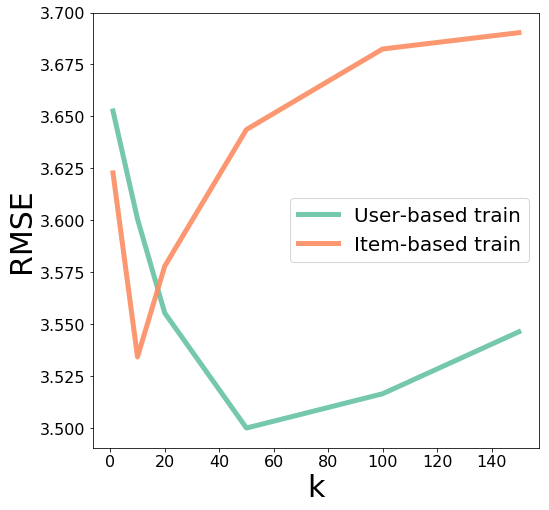

In [69]:
pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(minimum, user_rmse, c=pal[0], label='User-based train', alpha=0.9, linewidth=5)
plt.plot(minimum, item_rmse, c=pal[1], label='Item-based train', alpha=0.9, linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('k', fontsize=30)
plt.ylabel('RMSE', fontsize=30)

User-based collaborative filtering performed better than item-based. In practice, item-based tends to outperform user-based for most use cases. This might have happened due to the size of the data and also in a real world scenario the dataset has more users than items, specially in big companies. In our dataset, there are more items than users. 

Items are simpler than users since they belong to a small set of genres like seen in the data analysis step. The highest rated movie in this dataset is [Shawshank Redemption](https://www.imdb.com/title/tt0111161) and is classified as Drama. On the other hand, users tend to have very varied tastes. The same user might like Sci-Fi and Documentary movies which are very different genres. So item similarity is more meaningful than user similarity.

## Recommender <a name="recommender">
***
Since item-based CF tends to perfom better as a recommender system in general, let's do a full item-based recommender system and produce a recommendation for any new user. As always, we first need the user-item matrix.

In [70]:
user_item_matrix = ratings.pivot_table(index=['userId'],columns=['title'],values='rating')
user_item_matrix.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now let's compute the correlation between every column in the matrices using pearson correlation or centered cosine similarity.

In [71]:
corr_matrix = user_item_matrix.corr()
corr_matrix.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
title,,,,,,,,,,,,,,,,,,,,,
"""Great Performances"" Cats (1998)",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$9.99 (2008),NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Neath the Arizona Skies (1934),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The matrix above shows how each movie is correlated to other movies. For example, the movie ["Great Performances" Cats](https://www.imdb.com/title/tt0173714) is perfectly correlated to itself. As before, we do not want to focus on movies that have a small amount of behavior information. Let's not take into account pairs of movies that do not have at least 10 ratings. We chose 10 since item-based RMSE was the lowest with threshold of 10.

In [72]:
corr_matrix = user_item_matrix.corr(method='pearson', min_periods=10)
corr_matrix.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
title,,,,,,,,,,,,,,,,,,,,,
"""Great Performances"" Cats (1998)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$9.99 (2008),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Neath the Arizona Skies (1934),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Pandas makes it easy to choose the type of correlation we can use and also the minimum number of observations required per pair of columns to have a valid result. The resulting matrix shows that there are more NaNs. For example, the movie "Great Performances" Cats is no longer related to itself since it was not rated by at least 10 people. However, there are movies that still made the threshold and help to make more meaningful recommendations.  

Now let's make recommendations for a new user that we will create by combining other real users from the dataset. Then, let's perform item-based CF to make good movie recommendations. 

In [73]:
def create_new_user(k=3):
    while True:
        users = []
        # Randomly sample 5 elements from k users
        for i in range(k): 
            users.append(user_item_matrix.loc[i+1].dropna().sample(n=5))

        # create new user
        new_user = pd.concat(users)
        # make sure there are no duplicated movies
        if new_user.index.duplicated().all() == False:
            return new_user 

In [94]:
new_user = create_new_user()
new_user

title
Antz (1998)                                                  2.0
Tron (1982)                                                  4.0
Ben-Hur (1959)                                               2.0
Dracula (Bram Stoker's Dracula) (1992)                       3.5
Cape Fear (1991)                                             2.0
Clerks (1994)                                                1.0
Interview with the Vampire: The Vampire Chronicles (1994)    4.0
Little Women (1994)                                          4.0
Firm, The (1993)                                             4.0
Usual Suspects, The (1995)                                   4.0
Speed (1994)                                                 2.5
Shawshank Redemption, The (1994)                             5.0
Batman (1989)                                                3.0
Bowling for Columbine (2002)                                 3.5
Forrest Gump (1994)                                          5.0
dtype: float64

The *new_user* has rated [The Shawshank Redemption](https://www.imdb.com/title/tt0111161) 5 stars and [Forrest Gump](https://www.imdb.com/title/tt0109830) which are both Dramas. We should expect recommendations of Dramas. As well, *new_user* has rated several Horror movies.

So for each movie the *new_user* has rated, let's retrieve the list of similar movies from the correlation matrix. Then, let's scale those correlation scores by how well the new_user rated the movie they are similar to, so movies similar to ones the *new_user* liked count more than movies similar to ones the *new_user* disliked.

In [95]:
def recommender(user, corr_matrix):
    recommendations = pd.Series()
    for i in range(0, len(user.index)):
        # Retrieve similar movies to this one that new_user rated
        sims = corr_matrix[user.index[i]].dropna()
        # Now scale its similarity by how well new_user rated this movie
        sims = sims.map(lambda x: x * user[i])
        # Add the score to the list of recommendations
        recommendations = recommendations.append(sims)
    
    # sort recommendations
    recommendations.sort_values(inplace = True, ascending = False)
    return recommendations

In [96]:
sim_canditates = recommender(user=new_user,corr_matrix=corr_matrix)
sim_canditates = sim_canditates.groupby(sim_canditates.index).sum()

In [97]:
sim_canditates.sort_values(inplace=True, ascending=False)
sim_canditates.head(10)

Good Morning, Vietnam (1987)             18.459852
Jay and Silent Bob Strike Back (2001)    17.179406
Rocketeer, The (1991)                    16.959321
Addams Family, The (1991)                16.576830
Bug's Life, A (1998)                     16.558273
Splash (1984)                            16.068729
12 Angry Men (1957)                      15.835975
Hollow Man (2000)                        15.718926
Phenomenon (1996)                        15.712952
Patriot Games (1992)                     15.593009
dtype: float64

Above are the recommendations for the *new_user* we created. However, some might be repeated movies that the *new_user* has already rated. To give better recommendations, let's make sure we drop the movies the *new_user* has already rated.  

In [98]:
filtered_sims = sim_canditates.drop(sim_canditates[sim_canditates.index.isin(new_user.index)==True].index)
filtered_sims.head(10)

Good Morning, Vietnam (1987)             18.459852
Jay and Silent Bob Strike Back (2001)    17.179406
Rocketeer, The (1991)                    16.959321
Addams Family, The (1991)                16.576830
Bug's Life, A (1998)                     16.558273
Splash (1984)                            16.068729
12 Angry Men (1957)                      15.835975
Hollow Man (2000)                        15.718926
Phenomenon (1996)                        15.712952
Patriot Games (1992)                     15.593009
dtype: float64

[Good Morning, Vietnam](https://www.imdb.com/title/tt0093105) is the first recommendation for our *new_user* and it makes sense since it is a Drama movie. [Hollow Man](https://www.imdb.com/title/tt0164052/) is a Horror movie related and *new_user* has some Horror movies that has rated. However, since we made a randomly generated user, the tastes of the new_user vary and it recommends movies as well like A Bugs Life which should not be recommended since Antz was rated 2 by the user. Penalizing movies by the lower ratings the user gives should be a way to improve the recommender.


## Conclusion <a name="conclusion">
***
There are many ways of building a recommender systems. This project went over two different ways of implementing Collaborative Filtering. We covered Memory-based models which are based on similarity between items or users, where we used centered cosine-similarity, also known as pearson correlation. Using the metric RMSE we evaluated user-based and item-based algorithms and got the following results:

<div class="span5 alert alert-info">
User-Based CF RMSE: 3.5 with threshold 50
<br/>
Item-Based CF RMSE: 3.53 with threshold 10
</div>

User-based collaborative filtering proved to perform slightly better than item-based. However, item-based tends to be more robust recommender in a real world scenario. So, we tested a item-based CF on a new unseen user and performed well giving decent recommendations. However, there were as well some challenges faced on the project such as scalability. The project showcased a recommender with 671 users and 9,066 movies. If the data is increased, the CF algorithms suffer a drop in performance due to the increase in volume. Also, other technologies like Spark might be needed. 

Data sparsity was a challenge as well. The user-item matrix was large and sparse. Also in recommendation systems, there is a lack of diversity for recommendations. This is because popular items get recommended more often simply because of the fact that more users use and rate them. It's easy to imagine that a popular item will get a lot of ratings. So new movies will never be recommended.